# Chainer settings

In [1]:
#!/usr/bin/env python
#from __future__ import print_function
import argparse
import sys; sys.argv=['']; del sys

import gym

import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions
from chainer import Variable
import copy # test iterator copy

In [7]:
from skimage.color import rgb2gray
from skimage.transform import resize
import collections
import random
%matplotlib notebook
import matplotlib.pyplot as plt

In [8]:
class QFunction(chainer.Chain):
    def __init__(self, class_labels):
        initializer = chainer.initializers.HeNormal()
        c1 = 32
        c2 = 64
        c3 = 64
        c4 = 128

        super(QFunction, self).__init__(
             # the size of the inputs to each layer will be inferred
            conv1=L.Convolution2D(4, c1, 3, stride=1, pad=1),
            conv2=L.Convolution2D(32, c2, 3, stride=1, pad=1),
            conv3=L.Convolution2D(64, c3, 3, stride=1, pad=1),
            conv4=L.Convolution2D(64, c4, 3, stride=1, pad=1),
            fc1=L.Linear(4608, 1000, initialW=initializer),
            fc2=L.Linear(1000, class_labels, initialW=initializer),
            bnorm1=L.BatchNormalization(c1),
            bnorm2=L.BatchNormalization(c2),
            bnorm3=L.BatchNormalization(c3),
            bnorm4=L.BatchNormalization(c4),
        )

    def __call__(self, x):
        h = F.max_pooling_2d(F.relu(self.bnorm1(self.conv1(x))), 2, stride=2)
        h = F.max_pooling_2d(F.relu(self.bnorm2(self.conv2(h))), 2, stride=2)
        h = F.max_pooling_2d(F.relu(self.bnorm3(self.conv3(h))), 2, stride=2)
        h = F.max_pooling_2d(F.relu(self.bnorm4(self.conv4(h))), 2, stride=2)
        h = F.relu(self.fc1(h))
        y = self.fc2(h)        
        return y

In [9]:
STATE_LENGTH = 4  # Number of most recent frames to produce the input to the network
FRAME_WIDTH = 84  # Resized frame width
FRAME_HEIGHT = 84  # Resized frame height
replay_start_size = 500  # steps after which we start to update
sync_interval = 100  # interval of target sync
minibatch_size = 64  # size of minibatch
reward_scale = 1.0  # scale factor for rewards
steps_to_decay_epsilon = 5000  # steps to take to decay epsilon
min_epsilon = 0.01  # minimum value of epsilon
target_type = 'dqn'  # 'dqn' or 'double_dqn'

In [10]:
class MyAgent():
    
    def __init__(self, env, gpu_id = -1):
        self.env = env
        self.ndim_obs = env.observation_space.low.size
        self.n_actions = env.action_space.n
        
        self.state = None
        self.next_state = None
        self.reward = None
        self.action = None
        self.step = 0
        
        self.Q = QFunction(self.n_actions)
        self.target_Q = copy.deepcopy(self.Q)
        
        if gpu_id >= 0:
            chainer.cuda.get_device(gpu_id).use()  # Make a specified GPU current
            self.Q.to_gpu()  # Copy the model to the GPU
            
        self.optimizer = chainer.optimizers.Adam()
        self.optimizer.use_cleargrads()
        self.optimizer.setup(self.Q)
        
        self.D = collections.deque(maxlen=10 ** 6)  # replay memory

    def _preprocess_observation(self, obs):
        xp = self.Q.xp
        return xp.asarray(resize(rgb2gray(obs), (FRAME_WIDTH, FRAME_HEIGHT))*255, dtype=xp.uint8)
    
    def init_state(self, obs):
        xp = self.Q.xp
        processed_obs = self._preprocess_observation(obs)
        state = [processed_obs for _ in xrange(STATE_LENGTH)]
        self.state = xp.stack(state, axis=0)
        
    def _set_reward(self, reward):
        self.reward = reward
        
    def _set_observation(self, obs):
        xp = self.Q.xp
        processed_obs = self._preprocess_observation(obs)
        xp.append(self.state[1:, :, :], processed_obs[xp.newaxis], axis=0)
         
    def get_greedy_action(self):
        xp = self.Q.xp
        state = self.state.astype(xp.float32)[xp.newaxis]/255.
        with chainer.no_backprop_mode():
            q = self.Q(state).data[0]
        self.action = int(xp.argmax(q))
        return self.action

    def get_random_action(self):
        self.action = self.env.action_space.sample()
        return self.action
    
    def get_Q(self):
        return self.Q
    
    def get_optimizer(self):
        return self.optimizer

    def run(self, reward, done, new_obs):
        xp = self.Q.xp
        processed_obs = self._preprocess_observation(new_obs)
        new_state = xp.concatenate((self.state[1:, :, :], processed_obs[xp.newaxis]), axis=0)
        self.D.append((self.state, self.action, reward * reward_scale, done, new_state))
        self.state = new_state
        
        # Sample a random minibatch of transitions
        if len(self.D) >= replay_start_size:
            samples = random.sample(self.D, minibatch_size)
            self.update(samples, target_type=target_type)

        if self.step % sync_interval == 0:
            self.target_Q = copy.deepcopy(self.Q)

        self.step += 1
    
    def mean_clipped_loss(self, y, t):
        # Add an axis because F.huber_loss only accepts arrays with ndim >= 2
        y = F.expand_dims(y, axis=-1)
        t = F.expand_dims(t, axis=-1)
        return F.sum(F.huber_loss(y, t, 1.0)) / y.shape[0]
    
    def update(self, samples, gamma=0.99, target_type='double_dqn'):
        xp = self.Q.xp
        
        # Pack samples into arrays to enable batch computation
        # s = xp.asarray([sample[0] for sample in samples], dtype=np.float32) # too slow
        s = xp.stack([sample[0]/255. for sample in samples], axis=0).astype(xp.float32)
        a = xp.asarray([sample[1] for sample in samples], dtype=np.int32)
        r = xp.asarray([sample[2] for sample in samples], dtype=np.float32)
        done = xp.asarray([sample[3] for sample in samples], dtype=np.float32)
        # s_next = xp.asarray([sample[4] for sample in samples], dtype=np.float32)
        s_next = xp.stack([sample[4]/255. for sample in samples], axis=0).astype(xp.float32)
        
        # Prediction: Q(s,a)
        y = F.select_item(self.Q(s), a)
        # Target: r + gamma * max Q_b (s',b)
        with chainer.no_backprop_mode():
            if target_type == 'dqn':
                t = r + gamma * (1 - done) * F.max(self.target_Q(s_next), axis=1)
            elif target_type == 'double_dqn':
                t = r + gamma * (1 - done) * F.select_item(
                    self.target_Q(s_next), F.argmax(self.Q(s_next), axis=1))
            else:
                raise ValueError('Unsupported target_type: {}'.format(target_type))
        loss = self.mean_clipped_loss(y, t)
        self.Q.cleargrads()
        loss.backward()
        self.optimizer.update()
        
    def update_targetQ(self):
        self.target_Q = copy.deepcopy(self.Q)

<IPython.core.display.Javascript object>


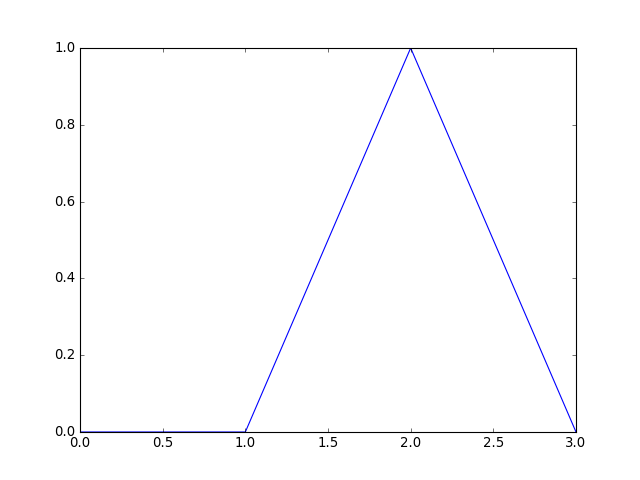

[2017-01-04 23:09:34,039] Making new env: Breakout-v0


episode: 0 step: 164 R:0.0 average_R:0.0
episode: 1 step: 333 R:0.0 average_R:0.0
episode: 2 step: 559 R:1.0 average_R:0.333333333333
episode: 3 step: 726 R:0.0 average_R:0.25


In [ ]:


# Initialize a figure
fig, ax = plt.subplots(1,1)

env_name = 'Breakout-v0'  # env to play
# Initialize an environment
env = gym.make(env_name)
agent = MyAgent(env, 0)
D = collections.deque(maxlen=10 ** 6)  # replay memory

render = True
Rs = []  # past returns

for episode in range(100):
    t = 0
    obs = env.reset()
    agent.init_state(obs)
    done = False
    limit = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
    R = 0
    
    while not done and t < limit:
        
        # Select an action
        epsilon = 1.0 if len(agent.D) < replay_start_size else \
            max(min_epsilon, np.interp(
                agent.step, [0, steps_to_decay_epsilon], [1.0, min_epsilon]))
        if np.random.rand() < epsilon:
            action_info = 'random'
            a = agent.get_random_action()
        else:
            action_info = 'greedy'
            a = agent.get_greedy_action()
        
        new_obs, r, done, info = env.step(a)
        D.append((obs, a, r * reward_scale, done, new_obs))
        agent.run(r, done, new_obs)
        #print('action:{}, reward:{}, done:{}, action_info:{}'.format(a, r, done, action_info))
        if render:
            env.render()
        t = t+1
    
        R += r
    # total reward
    Rs.append(R)
    average_R = np.mean(Rs[-100:])
    print('episode: {} step: {} R:{} average_R:{}'.format(
          episode, agent.step, R, average_R))
    ax.clear()
    ax.plot(Rs)
    fig.canvas.draw()

In [17]:
%%time
xp = agent.Q.xp
s = xp.asarray([sample[0] for sample in samples], dtype=np.float32)

CPU times: user 3.94 ms, sys: 0 ns, total: 3.94 ms
Wall time: 3.28 ms


In [18]:
%%time
xp = agent.Q.xp
s = xp.asarray([sample[0] for sample in samples], dtype=np.float32)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.8 ms


In [48]:
%%time
xp = agent.Q.xp
s = xp.asarray([sample[0] for sample in samples_agent], dtype=np.float32)

CPU times: user 7.87 s, sys: 595 ms, total: 8.46 s
Wall time: 8.49 s


In [84]:
%%time
xp = agent.Q.xp
s = xp.asarray([sample[4] for sample in samples_agent], dtype=np.float32)

CPU times: user 7.91 s, sys: 607 ms, total: 8.52 s
Wall time: 8.53 s


In [79]:
%%time
s = xp.stack([sample[0]/255. for sample in samples_agent], axis=0).astype(xp.float32)

CPU times: user 9.59 ms, sys: 12.1 ms, total: 21.7 ms
Wall time: 526 ms


In [80]:
s.max()

array(0.6000000238418579, dtype=float32)